**Mahya Ehsanimehr (9812762327)**

**Overview**

for this task, I have used multiple approaches. It seems that using pretained model of ResNet18 works better than VGG16 and VGG-face weights.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In this exercise we tend to predict the age of individuals with respect to the image of their face by transfer learnign.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

In [ ]:
# Transform on data
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.ColorJitter(),
        transforms.RandomVerticalFlip()
           ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    ]),
}

# getting data
data_dir = '/content/drive/MyDrive/datasets/Dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


**VGG16 and VGG-face weights**

here, I tried to use VGG16 as a pretrained model. And I also used VGG-face weights. However, I didn't get acceptable results. (the accuracy was fluctuating and under 30)

downloading the weights of VGG-face

In [ ]:
!wget http://www.robots.ox.ac.uk/~albanie/models/pytorch-mcn/vgg_face_dag.pth


--2024-01-08 16:22:56--  http://www.robots.ox.ac.uk/~albanie/models/pytorch-mcn/vgg_face_dag.pth
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~albanie/models/pytorch-mcn/vgg_face_dag.pth [following]
--2024-01-08 16:22:56--  https://www.robots.ox.ac.uk/~albanie/models/pytorch-mcn/vgg_face_dag.pth
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580015466 (553M)
Saving to: ‘vgg_face_dag.pth.1’

vgg_face_dag.pth.1  100%[===================>] 553.15M  29.0MB/s    in 20s     

2024-01-08 16:23:17 (27.9 MB/s) - ‘vgg_face_dag.pth.1’ saved [580015466/580015466]



I froze all layers except the last fully-connected.

In [ ]:
class VGG16Network(nn.Module):
    def __init__(self):
        super(VGG16Network, self).__init__()
        self.vgg16_model = models.vgg16(pretrained=False)

        vggface_weights = torch.load('/content/vgg_face_dag.pth')

        self.vgg16_model.load_state_dict(vggface_weights, strict=False)

        in_features = self.vgg16_model.classifier[6].in_features
        self.vgg16_model.classifier[6] = nn.Linear(in_features, len(class_names))

        for param in self.vgg16_model.parameters():
            param.requires_grad = False

        for param in self.vgg16_model.classifier[6].parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.vgg16_model(x)


**ResNet18**

All layers of ResNet are froze (using requires_grad = Flase) except the last two fully-connected layers which I designed manually. I also put a ReLU between these two layers. The results are still fluctuating. I utilized many approaches, like using one fully-connected, changing learning rate, using momentum, but they weren't successful.

In [ ]:
class ResNet18Network(nn.Module):
    def __init__(self):
        super(ResNet18Network, self).__init__()
        self.resnet = models.resnet18(pretrained=True)

        for name, param in self.resnet.named_parameters():
            if not name.startswith('fc'):
                param.requires_grad = False

        in_features = self.resnet.fc.in_features

        self.resnet.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Linear(512, len(class_names))
        )

    def forward(self, x):
        x = self.resnet(x)
        return x


**Train and Test Functions**

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase] * 100

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

**Build and Run Model**

specifying the random seed to start from the same point every time.

In [ ]:
import numpy as np
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

the results of ResNet18 (best test accuracy = 48)

In [ ]:
# create your model
modified_model = ResNet18Network().to(device)

# loss function
loss = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(params=modified_model.parameters() , lr= 0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# training
train_model(modified_model , loss , optimizer ,exp_lr_scheduler, num_epochs= 50)

Epoch 0/49
----------
train Loss: 1.6444 Acc: 14.4000
test Loss: 1.5700 Acc: 36.0000

Epoch 1/49
----------
train Loss: 1.6447 Acc: 10.4000
test Loss: 1.5402 Acc: 28.0000

Epoch 2/49
----------
train Loss: 1.6198 Acc: 18.4000
test Loss: 1.5489 Acc: 24.0000

Epoch 3/49
----------
train Loss: 1.6239 Acc: 19.2000
test Loss: 1.5447 Acc: 28.0000

Epoch 4/49
----------
train Loss: 1.6162 Acc: 22.4000
test Loss: 1.5412 Acc: 32.0000

Epoch 5/49
----------
train Loss: 1.6103 Acc: 25.6000
test Loss: 1.5423 Acc: 40.0000

Epoch 6/49
----------
train Loss: 1.6249 Acc: 17.6000
test Loss: 1.5377 Acc: 32.0000

Epoch 7/49
----------
train Loss: 1.5860 Acc: 20.0000
test Loss: 1.5461 Acc: 36.0000

Epoch 8/49
----------
train Loss: 1.5929 Acc: 24.8000
test Loss: 1.5428 Acc: 44.0000

Epoch 9/49
----------
train Loss: 1.5742 Acc: 30.4000
test Loss: 1.5305 Acc: 36.0000

Epoch 10/49
----------
train Loss: 1.5938 Acc: 24.8000
test Loss: 1.5471 Acc: 36.0000

Epoch 11/49
----------
train Loss: 1.5843 Acc: 26.400

ResNet18Network(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [ ]:
pip install scikit-learn


I also plotted the confusion matrix of my model to see where the most problem is. And it seems that the model has issues in detecting the age of elderly people (51-60).
I believe that these issues could h

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


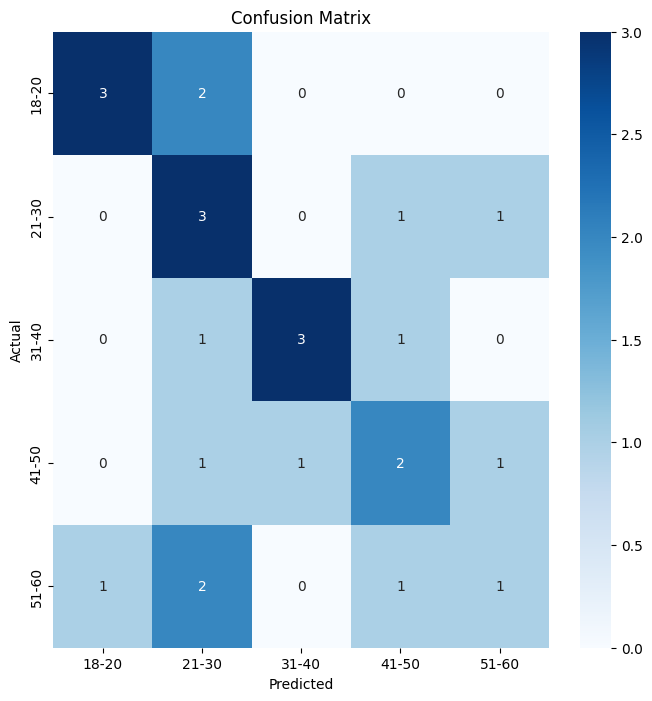

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.autograd import Variable

def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = Variable(inputs).to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

val_preds, val_labels = evaluate_model(modified_model, dataloaders['test'])
conf_matrix = confusion_matrix(val_labels, val_preds)

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()